# Experiment 1 

- Fine-tuning of the pre-trained TAPE model in a progressively specialized manner while extending the frozen layers
- Performance evaluation using two external datasets, Shomuradova and ImmuneCODE datatsets, which contain SARS-CoV-2 S-protein <sub>269~-277</sub>(YLQPRTFLL) epitope-specific TCR CDR3βs 

## Training process and model architecture


<img src='res/fig1.png' width='70%'>

Training process for the proposed model. The initial model is cloned from pre-trained Tasks Assessing Protein Embeddings (TAPE) model, adding a classification layer at the end. The pre-trained model is fine-tuned in two rounds in a progressively specialized manner while extending the frozen layers between rounds.

<img src='res/fig2.png' width='30%'>

The proposed model architecture. Input amino acid sequences concatenated by epitope and CDR3β sequences are first encoded into tokens using a tokenizer. Each token is then embedded into a 768-dimensional vector in the pre-trained Tasks Assessing Protein Embeddings (TAPE) model which has 12 encoding layers with 12 self-attention heads in each layer. The final classifier, a 2-layer feed forward network, is then used to predict either binder or not from the output of the TAPE model.

## Global configurations

In [1]:
import logging
import logging.config
import os
import sys
import warnings
from enum import auto
import pandas as pd
import numpy as np
from IPython.core.display import display

rootdir = '/home/hym/trunk/TCRBert'
workdir = '%s/notebook' % rootdir
datadir = '%s/data' % rootdir
srcdir = '%s/tcrbert' % rootdir
outdir = '%s/output' % rootdir

os.chdir(workdir)

sys.path.append(rootdir)
sys.path.append(srcdir)

from tcrbert.exp import Experiment
from tcrbert.predlistener import PredResultRecoder


# Display
pd.set_option('display.max.rows', 2000)
pd.set_option('display.max.columns', 2000)

# Logger
warnings.filterwarnings('ignore')
logging.config.fileConfig('../config/logging.conf')
logger = logging.getLogger('tcrbert')
logger.setLevel(logging.INFO)

# Target experiment
exp_key = 'exp1'
experiment = Experiment.from_key(exp_key)

exp_conf = experiment.exp_conf

display(exp_conf)

2022-11-04 17:58:44 [INFO]: Loaded exp_conf: {'title': 'exp1', 'description': 'Fine-tuning of pre-trained TAPE model in a progressively specialized manner', 'paper': 'exp1', 'model_config': '../config/bert-base/', 'outdir': '../output/exp1', 'train': {'pretrained_model': {'type': 'tape', 'location': '../config/bert-base/'}, 'data_parallel': False, 'backup': 'train.bak.{date}.tar.gz', 'rounds': [{'data': 'dash_vdjdb_mcpas', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 150, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_bert_encoders': [-10, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 15}, 'model_checkpoint': {'chk': 'train.{round}.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': 'train.{round}.result.json'}, {'data': 'iedb_sars2', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_ber

{'title': 'exp1',
 'description': 'Fine-tuning of pre-trained TAPE model in a progressively specialized manner',
 'paper': 'exp1',
 'model_config': '../config/bert-base/',
 'outdir': '../output/exp1',
 'train': {'pretrained_model': {'type': 'tape',
   'location': '../config/bert-base/'},
  'data_parallel': False,
  'backup': 'train.bak.{date}.tar.gz',
  'rounds': [{'data': 'dash_vdjdb_mcpas',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 150,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'optimizer': {'type': 'adam', 'lr': 0.0001},
    'train_bert_encoders': [-10, None],
    'early_stopper': {'monitor': 'accuracy', 'patience': 15},
    'model_checkpoint': {'chk': 'train.{round}.model_{epoch}.chk',
     'monitor': 'accuracy',
     'save_best_only': True,
     'period': 1},
    'result': 'train.{round}.result.json'},
   {'data': 'iedb_sars2',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 100,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'opt

## Fine-tuning datasets

In [2]:
from tcrbert.dataset import TCREpitopeSentenceDataset, CN
from tcrbert.commons import StrUtils


def summary_df(df):
    cols = ['Epitope species', 'Epitope gene', 'Epitope', 'MHC', 'Samples', 'Positives']
    rows = []
    for i, (epitope, subtab) in enumerate(df.groupby([CN.epitope])):
        row = subtab.iloc[0]
        especies = StrUtils.default_str(row[CN.epitope_species], '-')
        egene = StrUtils.default_str(row[CN.epitope_gene], '-')
        mhc = StrUtils.default_str(row[CN.mhc], '-')
        n_data = subtab.shape[0]
        n_pos = np.count_nonzero(subtab[CN.label] == 1)
#         print('%s: epitope: %s, species: %s, gene: %s, mhc: %s, n_data: %s, n_pos: %s' % 
#               (i, epitope, especies, egene, mhc, n_data, n_pos))
        rows.append([especies, egene, epitope, mhc, n_data, n_pos])
    
    return pd.DataFrame(rows, columns=cols)

for i, rnd in enumerate(exp_conf['train']['rounds']):
    data_key = rnd['data']
    train_ds = TCREpitopeSentenceDataset.from_key(data_key)
    train_df = train_ds.df_enc
    sent_encoder = train_ds.encoder
    
    print('Data for train round %s: %s' % (i, data_key))
    display(train_df.head(), train_df.shape)
    display(train_df[CN.label].value_counts())

    df_smry = summary_df(train_df)
    display(df_smry.head(), df_smry.shape)
    df_smry.to_csv('%s/summary_%s.csv' % (outdir, data_key))

2022-11-04 17:58:52 [INFO]: dash_vdjdb_mcpas dataset was loaded from ../output/dash_vdjdb_mcpas.data.csv, df.shape: (25138, 10)
Data for train round 0: dash_vdjdb_mcpas


,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,ref_id,label,sentence
GLCTLVAML_CASSLWTGSHEQYF,GLCTLVAML,BMLF,EBV,human,CASSLWTGSHEQYF,HLA-A*02:01,Dash,PMID:28636592,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CASSQSPGGEQYF,GLCTLVAML,BMLF,EBV,human,CASSQSPGGEQYF,HLA-A*02:01,Dash,PMID:28636592,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CASSLTTEQQFF,GLCTLVAML,BMLF,EBV,human,CASSLTTEQQFF,HLA-A*02:01,Dash,PMID:28636592,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CSARDATGNGYTF,GLCTLVAML,BMLF,EBV,human,CSARDATGNGYTF,HLA-A*02:01,Dash,PMID:28636592,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 22, 5..."
GLCTLVAML_CSARDSTGNGYTF,GLCTLVAML,BMLF,EBV,human,CSARDSTGNGYTF,HLA-A*02:01,Dash,PMID:28636592,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 22, 5..."


(25138, 10)

1    12569
0    12569
Name: label, dtype: int64

,Epitope species,Epitope gene,Epitope,MHC,Samples,Positives
0,Experimental autoimmune encephalomyelitis (EAE),-,ACASQKRPSQR,H-2u,42,21
1,HomoSapiens,GANAB,ALYGFVPVL,HLA-A*02:01,60,30
2,IAV,NP,ASNENMETM,H2-Db,570,285
3,HCV,NS3,ATDALMTGY,HLA-A*01,306,153
4,HCV,NS3,CINGVCWTV,HLA-A*02,86,43


(78, 6)

2022-11-04 17:58:56 [INFO]: iedb_sars2 dataset was loaded from ../output/iedb_sars2.data.csv, df.shape: (98563, 10)
Data for train round 1: iedb_sars2


,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,ref_id,label,sentence
FLPFFSNVTWFHAI_CASSIRSSYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIRSSYEQYF,HLA class I,IEDB,IEDB:1036945,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSIGVYGYTF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIGVYGYTF,HLA class I,IEDB,IEDB:1036945,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSIRSAYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIRSAYEQYF,HLA class I,IEDB,IEDB:1036945,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSSRSSYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSSRSSYEQYF,HLA class I,IEDB,IEDB:1036945,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSTRSAYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSTRSAYEQYF,HLA class I,IEDB,IEDB:1036945,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."


(98563, 10)

1    49282
0    49281
Name: label, dtype: int64

,Epitope species,Epitope gene,Epitope,MHC,Samples,Positives
0,SARS-CoV2,surface glycoprotein [Severe acute respiratory...,AEIRASANLAATK,HLA class I,214,107
1,SARS-CoV2,orf1ab polyprotein [Severe acute respiratory s...,AELAKNVSLDNVL,HLA class I,3588,1794
2,SARS-CoV2,membrane glycoprotein [Severe acute respirator...,AIAMACLVGLM,HLA class I,174,87
3,SARS-CoV2,orf1ab polyprotein [Severe acute respiratory s...,ALLADKFPV,HLA class I,42,21
4,SARS-CoV2,orf1ab polyprotein [Severe acute respiratory s...,ALRKVPTDNYITTY,HLA class I,692,346


(145, 6)

## Fine-tuning results

2022-11-04 17:59:33 [DEBUG]: Loaded backend module://matplotlib_inline.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
##############################
n_epochs: 150
stopped_epoch: 76
best_epoch: 61
best_score: 0.7783203125
best_chk: ../output/exp1/train.0.model_61.chk
##############################
n_epochs: 100
stopped_epoch: 16
best_epoch: 6
best_score: 0.9162298387096774
best_chk: ../output/exp1/train.1.model_6.chk


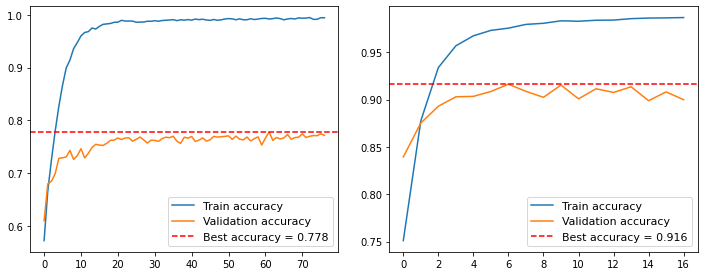

In [4]:
%pylab inline

def show_train_result(train_result=None, ax=None, title=None):
    df = pd.DataFrame({
        'train_loss': train_result['train.score']['loss'],
        'val_loss': train_result['val.score']['loss'],
        'train_accuracy': train_result['train.score']['accuracy'],
        'val_accuracy': train_result['val.score']['accuracy']
    })

    ax = df.loc[:, ['train_accuracy', 'val_accuracy']].plot(ax=ax, title=title)
    bs = train_result['best_score']
    n_epochs = train_result['stopped_epoch']
    ax.axhline(y=bs, ls='--', c='red')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend(["Train accuracy", "Validation accuracy", "Best accuracy = %0.3f" % bs], prop={"size": 11})
    
    print('##############################')
    print('n_epochs: %s' % train_result['n_epochs'])
    print('stopped_epoch: %s' % train_result['stopped_epoch'])
    print('best_epoch: %s' % train_result['best_epoch'])
    print('best_score: %s' % train_result['best_score'])
    print('best_chk: %s' % train_result['best_chk'])


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(4)
plt.tight_layout(h_pad=2, w_pad=2)

show_train_result(train_result=experiment.get_train_result(0), 
                  ax=axes[0])
show_train_result(train_result=experiment.get_train_result(1), 
                  ax=axes[1])


## Loading final fine-tuned model

In [5]:
model = experiment.load_eval_model()
display(model)

# Eval result recoder
eval_recoder = PredResultRecoder(output_attentions=True, output_hidden_states=True)
model.add_pred_listener(eval_recoder)

2022-11-04 17:59:40 [INFO]: Create TAPE model using config: ../config/bert-base/
2022-11-04 17:59:42 [INFO]: Loading the eval model from ../output/exp1/train.1.model_6.chk


BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
              (dropout): Drop

## Model evaluations

### Shomuradova <i>et al.</i>

- Performance evaluation for the dataset containing COVID-19 S-protein<sub>266-277</sub>(YLQPRTFLL) epitope-specific CDR3βs from  Shomuradova <i>et al.</i>

#### Loading eval dataset

In [6]:
from torch.utils.data import DataLoader
from tcrbert.dataset import TCREpitopeSentenceDataset
import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

epitope = 'YLQPRTFLL'

sh_ds = TCREpitopeSentenceDataset.from_key('shomuradova')
sh_df = sh_ds.df_enc

print(sh_ds.name)
display(sh_df.head(), sh_df.shape)
summary_df(sh_df)

2022-11-04 17:59:52 [INFO]: shomuradova dataset was loaded from ../output/shomuradova.data.csv, df.shape: (610, 9)
shomuradova


,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,label,sentence
YLQPRTFLL_CASSFQNTGELFF,YLQPRTFLL,Spike,SARS-CoV-2,HomoSapiens,CASSFQNTGELFF,HLA-A*02,Shomuradova,1,"[2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ..."
YLQPRTFLL_CASSSVNNNEQFF,YLQPRTFLL,Spike,SARS-CoV-2,HomoSapiens,CASSSVNNNEQFF,HLA-A*02,Shomuradova,1,"[2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ..."
YLQPRTFLL_CAVGEANTGELFF,YLQPRTFLL,Spike,SARS-CoV-2,HomoSapiens,CAVGEANTGELFF,HLA-A*02,Shomuradova,1,"[2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ..."
YLQPRTFLL_CAYQEVNTGELFF,YLQPRTFLL,Spike,SARS-CoV-2,HomoSapiens,CAYQEVNTGELFF,HLA-A*02,Shomuradova,1,"[2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 5, ..."
YLQPRTFLL_CSARDDQAVNTGELFF,YLQPRTFLL,Spike,SARS-CoV-2,HomoSapiens,CSARDDQAVNTGELFF,HLA-A*02,Shomuradova,1,"[2, 28, 15, 20, 19, 21, 23, 10, 15, 15, 7, 22,..."


(610, 9)

,Epitope species,Epitope gene,Epitope,MHC,Samples,Positives
0,SARS-CoV-2,Spike,YLQPRTFLL,HLA-A*02,610,305


#### Performance evaluation for Shomuradova dataset

In [9]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 792.1 kB/s eta 0:00:00a 0:00:01


2022-11-04 18:00:59 [DEBUG]: Loaded backend module://matplotlib_inline.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
2022-11-04 18:00:59 [INFO]: ======================
2022-11-04 18:00:59 [INFO]: Begin predict...
2022-11-04 18:00:59 [INFO]: use_cuda, device: False, cpu
2022-11-04 18:00:59 [INFO]: n_data: 610
2022-11-04 18:00:59 [INFO]: batch_size: 610
2022-11-04 18:00:59 [INFO]: [PredResultRecoder]: on_predict_begin...
2022-11-04 18:00:59 [INFO]: Begin 0/1 prediction batch
2022-11-04 18:01:28 [INFO]: End 0/1 prediction batch
2022-11-04 18:01:28 [INFO]: [PredResultRecoder]: on_predict_end...
2022-11-04 18:01:32 [INFO]: Done to predict...
2022-11-04 18:01:32 [INFO]: ======================
score_map: OrderedDict([('accuracy', 0.9245901639344263), ('f1', 0.923076923076923), ('roc_auc', 0.9675463585057781)])


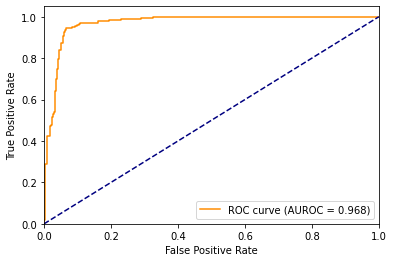

In [10]:
%pylab inline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import numpy as np

metrics = ['accuracy', 'f1', 'roc_auc']

data_loader = DataLoader(sh_ds, batch_size=len(sh_ds), shuffle=False, num_workers=2)
model.predict(data_loader=data_loader, metrics=metrics)
print('score_map: %s' % eval_recoder.result_map['score_map'])

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUROC = %0.3f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")



# Epitope-specific ROC curves
# epitopes = sh_df[CN.epitope].unique()

# fig, axes = plt.subplots(nrows=epitopes.shape[0], ncols=1)
# fig.set_figwidth(5)
# fig.set_figheight(4*len(epitopes))
# plt.tight_layout(h_pad=5, w_pad=3)

# for i, epitope in enumerate(epitopes):
#     indices = np.where(sh_df[CN.epitope] == epitope)[0]
# #     title = '%s-specific CDR3βs' % epitope
#     print(indices, len(indices))
#     title = None
#     ax = axes[i] if epitopes.shape[0] > 1 else axes
#     show_roc_curve(input_labels[indices], output_probs[indices], title=title, ax=ax)

#### Investigating position-wise attention weights 

##### Selecting target CDR3β sequences with most common lengths and predicted as a binder

2022-11-04 18:01:40 [DEBUG]: Loaded backend module://matplotlib_inline.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
cum_ratio: 157/293=0.5358361774744027
target_indices for 13: [  0   1   2   3   7   9  11  13  15  18  19  20  21  22  23  24  25  27
  28  31  32  33  35  37  38  39  43  51  57  59  62  65  67  70  71  72
  74  75  76  78  79  81  82  88  89  90  91  92  93  94  97  99 100 110
 111 113 115 117 118 119 120 122 123 124 127 129 134 138 139 142 146 147
 149 150 153 154 155 156 158 160 161 162 166 168 169 170 172 174 175 176
 177 178 179 180 185 186 189 190 192 193 194 197 198 201 202 203 205 207
 211 213 214 217 219 220 223 225 228 231 232 234 235 237 238 239 240 243
 244 245 247 250 251 252 256 260 261 263 266 267 268 270 271 273 275 277
 279 280 287 289 290 291 292 294 295 296 298 299 533](157)
cum_ratio: 212/293=0.7235494880546075
target_indices for 16: [  4  29  34  40  41  42  53  56  60  61  63  83  96 103 105 106 107 

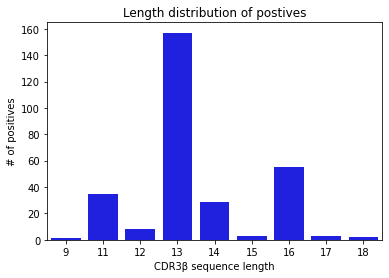

In [11]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter, OrderedDict

pos_indices = np.where(output_labels == 1)[0]
# print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
pos_cdr3b = sh_df[CN.cdr3b].values[pos_indices]

##########################################
lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
lens = np.array(lens)
cnts = np.array(cnts)
ax = sns.barplot(x=lens, y=cnts, color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('CDR3β sequence length')
ax.set_ylabel('# of positives')

# Select target indices by cdr3b sequence lenghts
target_index_map = OrderedDict()
order = np.argsort(cnts)[::-1]
cum_cnt = 0
for cur_len, cur_cnt in zip(lens[order], cnts[order]):
    cum_cnt += cur_cnt
    cum_ratio = cum_cnt/pos_indices.shape[0]
    print('cum_ratio: %s/%s=%s' % (cum_cnt, pos_indices.shape[0], cum_ratio))
    if cum_ratio < 0.9:
        target_indices = np.where((output_labels == 1) & (sh_df[CN.cdr3b].map(lambda x: len(x) == cur_len)))[0]
        print('target_indices for %s: %s(%s)' % (cur_len, target_indices, target_indices.shape[0]))
        target_index_map[cur_len] = target_indices



##### Marginalized position-wise attention weights for target YLQPRTFLL-CDR3b sequences 

- The output attention weights have the dimension $(L, N, H, S, S)$, where $L$ is the number of encoding layers, $N$ is the number of YLQPRTFLL-CDR3β sequence pairs, $H$ is the number of attention heads, and $S$ is the fixed-length of the sequences. The attention weights were marginalized into a one-dimensional vector of length of $S$. A value of the vector at the position $m$, $Am$ is given by the following equation:

<img src='res/eq1.png' width='50%'>

2022-11-04 18:01:58 [DEBUG]: Loaded backend module://matplotlib_inline.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 610, 12, 40, 40)
Attention weights for 13: [0.01966463 0.01826536 0.01552661 0.02397629 0.02000134 0.01694828
 0.0200967  0.02210921 0.02171671 0.0240711  0.02110009 0.02546916
 0.03219512 0.0352242  0.04054869 0.03684969 0.03136742 0.04027496
 0.0296776  0.02934217 0.02857662 0.02818676]
Attention weights for 16: [0.01928606 0.01773906 0.01581858 0.02255427 0.0198287  0.01743971
 0.01972822 0.02060298 0.02068313 0.02396294 0.01931677 0.02468455
 0.0256252  0.03458332 0.03398108 0.03596145 0.03450913 0.0417331
 0.03346071 0.02963817 0.03484081 0.02575049 0.02664396 0.02625029
 0.0288738 ]
Attention weights for 11: [0.01994438 0.01892149 0.01616089 0.02342424 0.01896035 0.01707706
 0.02214476 0.02131926 0.02148357 0.0282822  0.02099967 0.02564185
 0.02658938 0.03541161 0.03758298 0.03895745 0.03491269

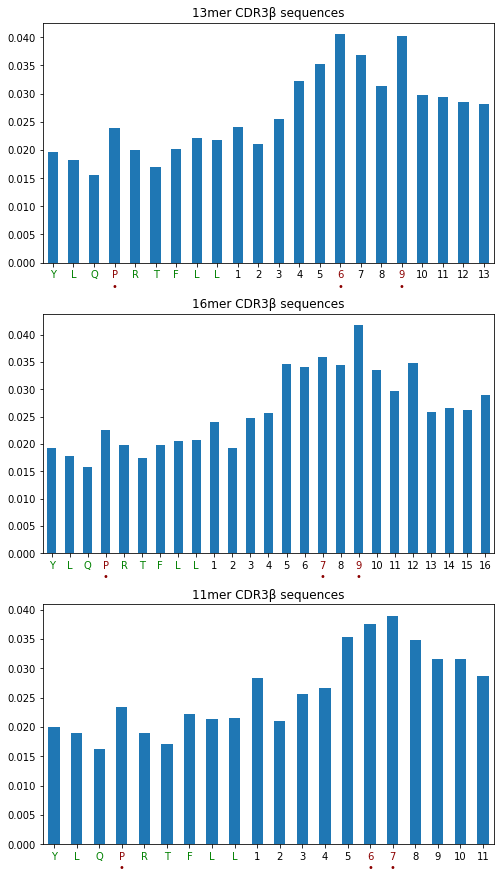

In [12]:
%pylab inline

# n_layers = model.config.num_hidden_layers
# n_data = len(eval_ds)
# n_heads = model.config.num_attention_heads
# max_len = eval_ds.max_len

epitope_len = len(epitope)

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

# target_attn_map = OrderedDict()

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_figwidth(7)
fig.set_figheight(12)
plt.tight_layout(h_pad=3, w_pad=3)

for i, (cur_len, cur_indices) in enumerate(target_index_map.items()):
    attns = attentions[:, cur_indices]
    sent_len = epitope_len + cur_len
    
    # Position-wise marginal attentions by mean
    attns = np.mean(attns, axis=(0, 1, 2, 3))[1:sent_len+1]
    print('Attention weights for %s: %s' % (cur_len, attns))
    
    ax = pd.Series(attns).plot(kind='bar', ax=axes[i], rot=0)
    ax.set_title('%smer CDR3β sequences' % cur_len)

    ticks = list(epitope) + list(range(1, cur_len + 1))
    mark_ratio = 0.1
    mark_pos = []

    for rank, pos in enumerate(np.argsort(attns[:epitope_len])[::-1]):
        if rank < (epitope_len*mark_ratio):
            ticks[pos] = '%s\n•' % (ticks[pos])
            mark_pos.append(pos)

    for rank, pos in enumerate(np.argsort(attns[epitope_len:])[::-1]):
        if rank < (cur_len*mark_ratio):
            ticks[epitope_len+pos] = '%s\n•' % (ticks[epitope_len+pos])
            mark_pos.append(epitope_len+pos)

    ax.set_xticklabels(ticks) 
    for i, tick in enumerate(ax.get_xticklabels()):
        if i < epitope_len:
            tick.set_color('green')
        else:
            tick.set_color('black')
        if i in mark_pos:
            tick.set_color('darkred')

### ImmuneCODE dataset

-  The dataset contained 718 COVID-19 S-protein<sub>269-277</sub>-specific TCRs from the ImmuneRACE study launched by Adaptive Biotechnologies and Microsoft (https://immunerace.adaptivebiotech.com, June 10, 2020 dataset, from hereafter referred to as ImmuneCODE dataset

#### Loading eval dataset

In [13]:
im_ds = TCREpitopeSentenceDataset.from_key('immunecode')
display(im_ds.name, len(im_ds))

# Remove duplicated CDR3beta seqs with Shomuradova
im_ds.df_enc = im_ds.df_enc[
        im_ds.df_enc[CN.cdr3b].map(lambda seq: seq not in sh_df[CN.cdr3b].values)
]
im_df = im_ds.df_enc
print('After removing duplicates, len(im_ds): %s' % len(im_ds))
display(summary_df(im_df), im_df.shape)

2022-11-04 18:02:04 [INFO]: immunecode dataset was loaded from ../output/immunecode.data.csv, df.shape: (742, 9)


'immunecode'

742

After removing duplicates, len(im_ds): 718


,Epitope species,Epitope gene,Epitope,MHC,Samples,Positives
0,SARS-CoV-2,Spike,YLQPRTFLL,-,718,328


(718, 9)

#### Performance evaluation for the ImmuneCODE dataset

2022-11-04 18:02:08 [DEBUG]: Loaded backend module://matplotlib_inline.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
2022-11-04 18:02:08 [INFO]: ======================
2022-11-04 18:02:08 [INFO]: Begin predict...
2022-11-04 18:02:08 [INFO]: use_cuda, device: False, cpu
2022-11-04 18:02:08 [INFO]: n_data: 718
2022-11-04 18:02:08 [INFO]: batch_size: 718
2022-11-04 18:02:08 [INFO]: [PredResultRecoder]: on_predict_begin...
2022-11-04 18:02:08 [INFO]: Begin 0/1 prediction batch
2022-11-04 18:02:54 [INFO]: End 0/1 prediction batch
2022-11-04 18:02:54 [INFO]: [PredResultRecoder]: on_predict_end...
2022-11-04 18:02:58 [INFO]: Done to predict...
2022-11-04 18:02:58 [INFO]: ======================
score_map: OrderedDict([('accuracy', 0.9596100278551533), ('f1', 0.9559939301972684), ('roc_auc', 0.9843339587242026)])


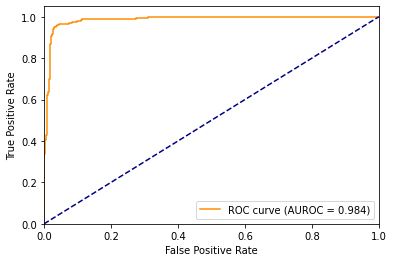

In [14]:
%pylab inline

from sklearn.metrics import roc_curve, auc

data_loader = DataLoader(im_ds, batch_size=len(im_ds), shuffle=False, num_workers=2)
model.predict(data_loader=data_loader, metrics=metrics)

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUROC = %0.3f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

print('score_map: %s' % eval_recoder.result_map['score_map'])

#### Investigating position-wise attention weights

##### Selecting target CDR3β sequences with most common lengths and predicted as a binder

2022-11-04 18:03:02 [DEBUG]: Loaded backend module://matplotlib_inline.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
cum_ratio: 164/331=0.4954682779456193
target_indices for 13: [  0   2   5   9  10  11  16  17  18  21  23  27  28  30  32  33  36  40
  41  43  44  45  46  47  48  51  55  56  60  63  65  68  69  71  72  74
  75  77  81  84  85  86  87  90  93  94 100 105 106 107 109 110 111 112
 113 114 115 118 126 127 129 131 133 135 138 140 145 147 148 151 154 156
 157 163 166 167 168 170 172 174 175 176 177 181 183 184 188 190 191 192
 194 196 199 200 201 202 203 204 207 208 209 210 211 216 219 220 222 223
 224 226 230 231 233 234 235 239 240 247 254 255 256 258 259 260 261 263
 264 265 269 280 281 282 283 286 289 290 292 293 295 297 298 299 304 306
 308 310 312 314 317 318 319 320 321 323 324 325 326 327 406 492 544 562
 605 648](164)
cum_ratio: 221/331=0.6676737160120846
target_indices for 14: [  7  22  29  37  39  49  52  53  54  78

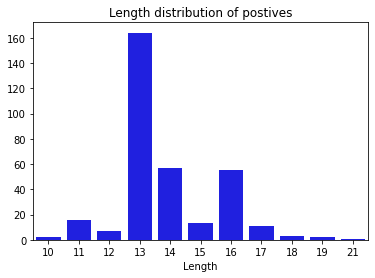

In [15]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter, OrderedDict

pos_indices = np.where(output_labels == 1)[0]
# print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
pos_cdr3b = im_df[CN.cdr3b].values[pos_indices]

##########################################
lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
lens = np.array(lens)
cnts = np.array(cnts)
ax = sns.barplot(x=lens, y=cnts, color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('Length')

# Select target indices by cdr3b sequence lenghts
target_index_map = OrderedDict()
order = np.argsort(cnts)[::-1]
cum_cnt = 0
for cur_len, cur_cnt in zip(lens[order], cnts[order]):
    cum_cnt += cur_cnt
    cum_ratio = cum_cnt/pos_indices.shape[0]
    print('cum_ratio: %s/%s=%s' % (cum_cnt, pos_indices.shape[0], cum_ratio))
    if cum_ratio < 0.85:
        target_indices = np.where((output_labels == 1) & (im_df[CN.cdr3b].map(lambda x: len(x) == cur_len)))[0]
        print('target_indices for %s: %s(%s)' % (cur_len, target_indices, target_indices.shape[0]))
        target_index_map[cur_len] = target_indices


##### Marginalized position-wise attention weights for target YLQPRTFLL-CDR3b sequences 

2022-11-04 18:03:07 [DEBUG]: Loaded backend module://matplotlib_inline.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 718, 12, 40, 40)
Current attns for 13: [0.01735935 0.01708608 0.01536453 0.02015801 0.01903374 0.01670946
 0.01708164 0.02129697 0.0207544  0.02252298 0.02222642 0.02575715
 0.03550188 0.03562678 0.044368   0.04023289 0.03409526 0.04163858
 0.03056774 0.03131856 0.02817524 0.02717155]
Current attns for 14: [0.01675993 0.01719913 0.01533338 0.01897495 0.01963613 0.01730148
 0.0174872  0.02017067 0.02024132 0.02227175 0.02104763 0.02605347
 0.03206035 0.03493004 0.0448724  0.0373659  0.03685395 0.03776319
 0.04027747 0.03114163 0.02851438 0.02911451 0.02823095]
Current attns for 16: [0.01701309 0.0165045  0.01588076 0.01926141 0.01884009 0.01764992
 0.01673837 0.01893845 0.01961652 0.02197684 0.01963977 0.02566578
 0.02713325 0.03510608 0.0373208  0.03979139 0.03734439 0.04241529
 0.03605229 0.03326917

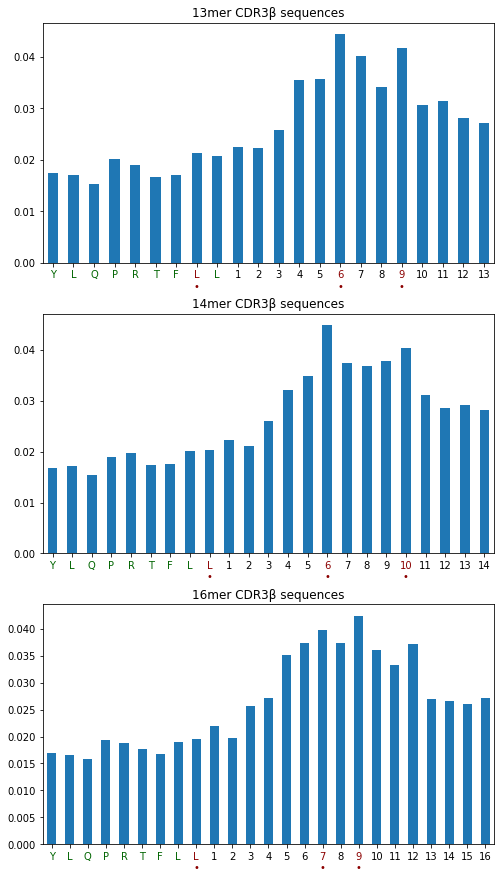

In [16]:
%pylab inline

# n_layers = model.config.num_hidden_layers
# n_data = len(eval_ds)
# n_heads = model.config.num_attention_heads
# max_len = eval_ds.max_len

epitope_len = len(epitope)

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

# target_attn_map = OrderedDict()

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_figwidth(7)
fig.set_figheight(12)
plt.tight_layout(h_pad=3, w_pad=3)

for i, (cur_len, cur_indices) in enumerate(target_index_map.items()):
    attns = attentions[:, cur_indices]
    sent_len = epitope_len + cur_len
    
    # Position-wise marginal attentions by mean
    attns = np.mean(attns[-10:], axis=(0, 1, 2, 3))[1:sent_len+1]
    print('Current attns for %s: %s' % (cur_len, attns))
    
    ax = pd.Series(attns).plot(kind='bar', ax=axes[i], rot=0)
    ax.set_title('%smer CDR3β sequences' % cur_len)

    ticks = list(epitope) + list(range(1, cur_len + 1))
    mark_ratio = 0.1
    mark_pos = []

    for rank, pos in enumerate(np.argsort(attns[:epitope_len])[::-1]):
        if rank < (epitope_len*mark_ratio):
            ticks[pos] = '%s\n•' % (ticks[pos])
            mark_pos.append(pos)

    for rank, pos in enumerate(np.argsort(attns[epitope_len:])[::-1]):
        if rank < (cur_len*mark_ratio):
            ticks[epitope_len+pos] = '%s\n•' % (ticks[epitope_len+pos])
            mark_pos.append(epitope_len+pos)

    ax.set_xticklabels(ticks) 
    for i, tick in enumerate(ax.get_xticklabels()):
        if i < epitope_len:
            tick.set_color('darkgreen')
        else:
            tick.set_color('black')
        if i in mark_pos:
            tick.set_color('darkred')
    
